# Análisis y graficación de recorridos GPX (optativa)

Los ciclistas, los maratonistas también,  suelen guardar y procesar en  la computadora los recorridos que realizan para luego analizar su desempeño. No solo se guarda el recorrido sino  también otros datos relevantes, en el caso del ciclismo: elevación, tiempo (en cada punto del recorrido), ritmo cardiaco,  cadencia, potencia, temperatura ambiental,  etc.

La adquisición de datos se realiza por medio de computadora,  reloj o celular y, por supuesto, depende de los sensores disponibles al momento de hacer el recorrido.

El almacenamiento de los datos se hace en un archivo y unos de los formatos más utilizados para almacenar este tipo de datos es GPX,  que es un formato  básico que tiene muchas extensiones.

El formato GPX (GPS Exchange Format) es un estándar abierto para el intercambio de datos de GPS (Global Positioning System) entre aplicaciones, dispositivos y servicios. Es un formato de archivo XML que contiene información sobre la posición geográfica, la altitud, la velocidad y el tiempo de un registro de seguimiento GPS.

El formato GPX se utiliza comúnmente en aplicaciones y servicios de navegación, como Google Maps, MapMyRun, Strava y otros. También es compatible con una amplia gama de dispositivos GPS, como relojes deportivos, dispositivos de navegación portátiles y teléfonos inteligentes.

Además de la información de seguimiento GPS, el formato GPX también puede contener otros datos relevantes, como notas, fotos y enlaces a sitios web relacionados con la ubicación. Los archivos GPX se pueden editar y compartir fácilmente y se han convertido en un formato popular para compartir rutas y registros de seguimiento entre atletas, excursionistas, ciclistas y otros entusiastas de las actividades al aire libre.

En  este cuaderno analizaremos y procesaremos archivos GPX de un recorrido y graficaremos  algunos resultados que puedan resultar de interés.

## 1. Lectura y procesamiento de recorridos GPX



Los archivos GPX son XML y  en su forma más sencila estos registros contienen una serie de datos con la siguiente imformación

- latitud y longitud (decimales)
- elevación (metros sobre al nivel del mar)

En el XML de los archivos GPX estos datos están representados de la siguiente manera,  por ejemplo,

      <trkpt lat="-31.396528892219066619873046875" lon="-64.46706810034811496734619140625">
        <ele>662</ele>
      </trkpt>

Es decir la tag de los elementos principales es `trkpt`, la latitud y longitud son atributos de cada uno de esos elementos. A su vez cada elemento `trkpt` contiene un elemento `ele` que da la elevación en metros de ese punto.

En  la computadora,  entonces un recorrido se representa con un archivo con  cierta cantidad de muestras y cada muestra se representa con un `<trkpt> ... </trkpt>`.
Como estamos usando Colab, lo primero que debemos hacer es cargar archivos GPX en "Archivos" de este cuaderno.

In [ ]:
# Esta celda de código es para cargar el archivo en "Archivos" de este cuaderno.
# No hace falta si estamos trabajando en nuestra computadora y el archivo se encuentra localmente
import requests
archivos = ['Ascochinga_MTB.gpx', 'Punilla_MTB.gpx', 'Punilla_Observatorio.gpx']
for archivo in archivos:
    url = 'https://raw.githubusercontent.com/tirabo/Algoritmos-y-Programacion/main/2023/archivos/' + archivo
    response = requests.get(url)

    if response.status_code == 200:
        datos = response.text # datos es una str
        with open('/content/' + archivo, 'w') as f:
            f.write(datos)
    else:
        print('Hubo un problema al cargar el archivo')


La celda anterior carga "localmente" tres archivos GPX.

En la siguiente celda cargamos la bibliotecas que nos interesana así como dos constantes.

In [ ]:
import numpy as np
from xml.dom import minidom
from  math import *
from dateutil.parser import parse

R = 6371000 # radio terrestre en metros
PI = np.pi # el pi de numpy

En  la siguiente celda definimos una función que lee el archivo GPX y devuelve 3 arreglos Numpy: `latitud`, `longitud` y `elevacion`. Es decir,  si `0 <= i < len(latitud)`,  entonces `latitud[i]`, `longitud[i]`, `elevacion[i]` son las latitud y longitud geográficas y la elevacón en la muestra $i$.

In [ ]:
def leer_gpx(nombre: str):
    # pre: nombre es el archivo a ser leido (poner path completo ./bicicleta/gpx/altas_cumbres.gpx, por ejemplo)
    # post: devuelve una lista de 3-uplas (latitud, longitud,  elevacion)
    lat, lon, ele = np.array([]), np.array([]), np.array([]) # datos obligatorios
    # Parsear el documento
    doc = minidom.parse(nombre)
    # getElementsByTagName() devuelve una lista de
    # elementos con el nombre dado. Aquí <trkpt>
    for ubicacion in doc.getElementsByTagName('trkpt'):
        # getAttribute() devuelve un valor asociado a una clave dada
        # dentro de una etiqueta.
        latitud_p =  radians(float(ubicacion.getAttribute('lat')))
        longitud_p = radians(float(ubicacion.getAttribute('lon')))
        # 1. De nuevo getElementsByTagName() devuelve una lista.
        # 2. Usamos sólo el primer elemento de la lista ([0]).
        # 3. De ahí obtenemos el primer hijo (puede ser un nodo de datos
        # u otro elemento)
        # 4. Del nodo de datos obtenemos los datos reales
        elevacion_p =  float(ubicacion.getElementsByTagName('ele')[0].firstChild.data)
        # latitud, longitud, elevacion son obligatorios en el archivo gpx
        lat = np.append(lat, latitud_p)
        lon = np.append(lon, longitud_p)
        ele = np.append(ele, elevacion_p)
    return  (lat, lon, ele)

Veamos si funciona:

In [ ]:
archivo = archivos[1]
leer_gpx('/content/' + archivo)
# lat="-31.403840000000002" lon="-64.5113" <ele>657.8000000000001</ele>

(array([-0.54810041, -0.54808941, -0.54808208, ..., -0.54835121,
        -0.54835121, -0.5483547 ]),
 array([-1.12593459, -1.1259414 , -1.12594541, ..., -1.12568047,
        -1.12567646, -1.12566755]),
 array([657.8 , 658.06, 657.83, ..., 647.98, 647.98, 647.81]))

Con estos datos podemos hacer algunos cálculos: distancias parciales y distancia total recorrida y pendiente instantanea.  Para poder calcular esto  primero necesitamos definir una función que nos de la distancia de dos puntos sobre la tierra.


In [ ]:
def calc_distancia(punto1, punto2):
    # pre:  punto1 y punto2 son coordenadas de dos puntos en radianes y su elevación en metros.
    # post: distancia entre los dos puntos en metros
    lat1, lon1, ele1 = punto1[0], punto1[1], punto1[2]
    lat2, lon2, ele2 = punto2[0], punto2[1], punto2[2]
    dif_ele = ele2 - ele1
    dist_plana = R*acos(cos(lat1)*cos(lat2)*cos(lon1-lon2) + sin(lat1)*sin(lat2)) # en metros
    return  (dist_plana**2 + dif_ele**2)**0.5

Ahora sí podemos recuperar latitud, longitud, elevacion, distancia total desde el origen hasta ese punto y pendiente, que es el porcentaje de elevación entre ese punto y el anterior (la primera pendiente es 0.0)

In [ ]:
def recorrido_proc(lat, lon, ele):
    # pre: recorrido es una lista de ternas de (latitud, longitud, elevacion)
    # post: devuelve una 5-upla (latitud, longitud, elevacion, distancia, pendiente) donde
    #       - distancia en una coordenada es la distancia total desde el origen hasta ese punto
    #       - pendiente es el % de elevación entre ese punto y el anterior (la primera es 0.0)
    dis, pen = np.array([0]), np.array([0])
    distancia_total = 0
    for i in range(1, len(lat)):
        # distancia total
        dist = calc_distancia((lat[i-1], lon[i-1], ele[i-1]), (lat[i], lon[i], ele[i]))
        distancia_total += dist
        dis = np.append(dis, distancia_total)
        # pendiente
        dist_plana = R*acos(cos(lat[i-1])*cos(lat[i])*cos(lon[i-1]-lon[i]) + sin(lat[i-1])*sin(lat[i]))
        if dist_plana != 0:
            pendiente = 100 * (ele[i] - ele[i-1]) / dist_plana
        pen = np.append(pen, pendiente)
    return lat, lon, ele, dis, pen

Podemos entonces aplicar esta función a un archivo GPX y almacenar los resultados

In [ ]:
archivo = archivos[1]
lectura_gpx = leer_gpx('/content/' + archivo)
latitud, longitud, elevacion, distancia, pendiente = recorrido_proc(lectura_gpx[0], lectura_gpx[1], lectura_gpx[2])

Entonces, por ejemplo, imprimamos la distancia recorrida, la elevación y la pendiente en los primeros 30 puntos.

In [ ]:
print('Distancia rec.    Elevación    Pendiente')
for i in range(30):
    print(round(distancia[i],1),'    \t', round(elevacion[i],1),'    \t', round(pendiente[i],1))

Distancia rec.    Elevación    Pendiente
0.0     	 657.8     	 0.0
79.2     	 658.1     	 0.3
130.8     	 657.8     	 -0.4
182.3     	 658.6     	 1.5
190.0     	 658.8     	 2.9
197.9     	 659.0     	 1.8
294.6     	 659.9     	 1.0
391.2     	 661.9     	 2.1
487.9     	 664.5     	 2.7
584.5     	 666.9     	 2.4
639.1     	 668.1     	 2.2
693.7     	 670.0     	 3.4
694.9     	 670.0     	 0.0
761.0     	 673.5     	 5.3
827.2     	 676.4     	 4.4
892.0     	 671.3     	 -7.9
950.2     	 668.6     	 -4.7
1001.7     	 667.3     	 -2.4
1062.2     	 667.4     	 0.2
1110.3     	 668.2     	 1.6
1133.4     	 668.4     	 0.7
1158.2     	 668.5     	 0.5
1239.0     	 671.9     	 4.2
1320.3     	 682.3     	 12.8
1325.4     	 683.8     	 31.4
1333.1     	 683.8     	 0.0
1355.1     	 688.1     	 19.9
1366.8     	 689.4     	 11.7
1379.2     	 690.7     	 9.9
1419.8     	 694.7     	 10.1


Podemos también obtener la distancia total del trayecto:

In [ ]:
n = len(distancia)
print('Distancia total del trayecto:',round(distancia[n - 1] /1000, 1), 'km')

Distancia total del trayecto: 43.4 km


Otro dato que le interesa a los deportistas que hace recorridos es la altura positiva acumulada,  es decir los metros que han subido (sin importar los que han bajado).

In [ ]:
def declive_acumulado_positivo(elevacion):
    # pre: elevacion es un array numpy con los datos de altura en cada punto del recorrido (interpolados)
    # post: devuelve el declive acumulado positivo
    declive_acumulado = 0
    for i in range(1, len(elevacion)):
        if elevacion[i] - elevacion[i-1] > 0:
            declive_acumulado += elevacion[i] - elevacion[i-1]
    return declive_acumulado

En  este caso:

In [ ]:
print('Altura acumulada positiva:',round(declive_acumulado_positivo(elevacion)), 'metros')

Altura acumulada positiva: 945 metros


##2. Algunos gráficos relacionados con recorridos GPX

En las aplicaciones destinadas al deporte se dibujan algunos cuadros que pueden ser de interés para el deportista y  que surgen del procesamiento de los datos de los recorridos GPX.

En  este caso lo más interesante para dibujar o graficar es el "perfil"  del recorrido,  es decir la elevación en función de la distancia.

Primero debemos importar el módulo `pyplot`:

In [ ]:
import matplotlib.pyplot as plt

Entonces graficamos de la siguiente manera:

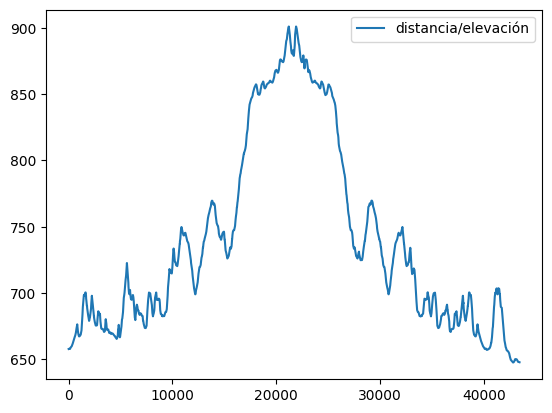

In [ ]:
# Dibujamos distancia vs elevación
plt.plot(distancia, elevacion, label='distancia/elevación')
plt.legend()
plt.show()

La relativa simetría respecto a la recta que pasa por el centro del cuadro se debe a que es un recorrido "de ida y vuelta". Grafiquemos los datos de latitud y longitud como si la Tierra fuera plana:


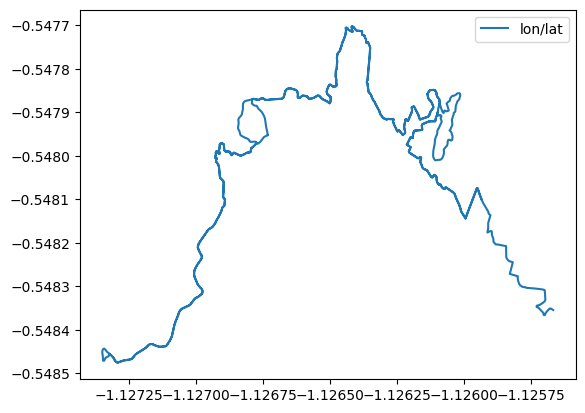

In [ ]:
plt.plot(longitud, latitud, label='lon/lat')
plt.legend()
plt.show()

No hay simetría absoluta,  debido a que la vuelta no es por el mismo lugar que la ida.

Podemos  dibujar una animación del recorrido con el código de la siguiente celda, pero en Colab no se puede apreciar.

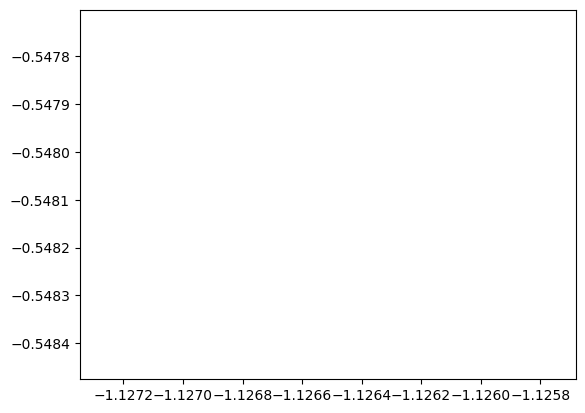

In [ ]:
from matplotlib.animation import FuncAnimation

# Grafiquemos el recorrido animado
# Si lo hacemos con todos los puntos será muy lento
velocidad_de_animacion = 5 # cada velocidad_de_animacion  puntos se muestra uno
# Configuración de la figura y el eje
indices = np.arange(0, len(longitud), velocidad_de_animacion)
lon_new, lat_new = longitud[indices], latitud[indices]

fig, ax = plt.subplots()
line, = ax.plot([], [])
ax.set_xlim(np.min(lon_new), np.max(lon_new))
ax.set_ylim(np.min(lat_new), np.max(lat_new))

# Función de actualización de la animación
def update(frame):
    x = lon_new[:frame+1]
    y = lat_new[:frame+1]
    line.set_data(x, y)
    return line,

# Función de inicialización de la animación
def init():
    line.set_data([], [])
    return line,

# Creación de la animación
ani = FuncAnimation(fig, update, frames=len(lon_new), init_func=init, blit=True)

# Mostrar la animación
plt.show()

##3. Recorridos GPX generados por una actividad

En  el caso de recorridos generados a partir de una actividad,  cada muestra (`<trkpt> ... </trkpt>`) puede contener datos adicionales. Estos registros contienen puntos que describen el recorrido y  en cada punto tenemos, por ejemplo,  la siguiente imformación


- latitud y longitud (decimales)
- elevación (metros sobre al nivel del mar)
- tiempo (día y hora)
- temperatura ambiental (en grados centígrados)
- ritmo cardiaco (pulsaciones por minuto)
- cadencia (revoluciones por minuto del pedal)

En XML  estos datos están representados de la siguiente manera,  por ejemplo,

      <trkpt lat="-31.396528892219066619873046875" lon="-64.46706810034811496734619140625">
        <ele>662</ele>
        <time>2023-03-01T19:17:48.000Z</time>
        <extensions>
          <ns3:TrackPointExtension>
            <ns3:atemp>33.0</ns3:atemp>
            <ns3:hr>152</ns3:hr>
            <ns3:cad>65</ns3:cad>
          </ns3:TrackPointExtension>
        </extensions>
      </trkpt>

A  continuación tomaremos en cuenta estos datos y calcularemos, por ejemplo, las pulsaciones medias del ciclista o la duración del recorrido. También graficaremos diversos aspectos del recorrido.

El código para ler un archivo GPX con estos datos es una extensión o ampliación del código anterior y es un poco más complicado.


In [ ]:
def leer_gpx(nombre: str):
    # pre: nombre es el archivo a ser leido (poner path completo ./bicicleta/gpx/altas_cumbres.gpx, por ejemplo)
    # post: devuelve una lista de 3-uplas (latitud, longitud,  elevacion)
    recorrido = []
    lat, lon, ele = np.array([]), np.array([]), np.array([]) # datos obligatorios
    time, temp, heart_rate, cadence = np.array([]), np.array([]), np.array([]), np.array([]) # datos opcionales (solo si es un recorrido realizado)
    # Parse the document
    doc = minidom.parse(nombre)
    # getElementsByTagName() returns a list of
    # elements with the given name. Here <trkpt>
    for ubicacion in doc.getElementsByTagName('trkpt'):
        # getAttribute() returns a value associated with a given key
        # within a tag. Here <species name='xxxxx'>
        latitud_p =  radians(float(ubicacion.getAttribute('lat')))
        longitud_p = radians(float(ubicacion.getAttribute('lon')))
        # 1. Again getElementsByTagName() returns a list.
        # 2. We use just the first element of the list ([0]).
        # 3. From that we obtain the first child (could be a data node
        # or another element)
        # 4. From the data node we obtain the actual data
        # Here: <common-name>xxxx</common-name>
        elevacion_p =  float(ubicacion.getElementsByTagName('ele')[0].firstChild.data)
        # latitud, longitud, elevacion son obligatorios en el archivo gpx
        lat = np.append(lat, latitud_p)
        lon = np.append(lon, longitud_p)
        ele = np.append(ele, elevacion_p)

        # EXTENSIONES PARA RECORRIDOS REALIZADOS:
        #   hora, temperatura ambiente, ritmo cardiaco y cadencia.
        data =  ubicacion.getElementsByTagName('time')
        if len(data) > 0:
            date_str = data[0].firstChild.data
            time_epoch = int(parse(date_str).timestamp()) # convierte "2023-02-16T19:18:18.000Z" a segundos desde 1970
            time = np.append(time,time_epoch)
        else:
            time = np.append(time, np.nan)
        if len(ubicacion.getElementsByTagName('ns3:atemp')) > 0:
            temp = np.append(temp, float(ubicacion.getElementsByTagName('ns3:atemp')[0].firstChild.data))
        else:
            temp = np.append(temp, np.nan)
        if len(ubicacion.getElementsByTagName('ns3:hr')) > 0:
            heart_rate = np.append(heart_rate, float(ubicacion.getElementsByTagName('ns3:hr')[0].firstChild.data))
        else:
            heart_rate = np.append(heart_rate, np.nan)
        if len(ubicacion.getElementsByTagName('ns3:cad')) > 0:
            cadence = np.append(cadence, float(ubicacion.getElementsByTagName('ns3:cad')[0].firstChild.data))
        else:
            cadence = np.append(cadence, np.nan)
        # FIN EXTENSIONES

    return  (lat, lon, ele, time, temp, heart_rate, cadence)

Ahora podemos definir diferentes funciones de utilidad.

In [ ]:
def velocidad_instantanea(distancia, tiempo):
    # pre: distancia es un array numpy con los datos de distancia que devuelve recorrido_proc()
    #      tiempo es un array numpy con los datos de tiempo que devuelve leer_gpx()
    # post: devuelve la velocidad instantánea en cada punto del recorrido
    diferencia_dist, diferencia_tiempo = np.diff(distancia).copy(), np.diff(tiempo).copy()
    diferencia_dist = np.insert(diferencia_dist, 0, 0.0) # agrega un 0 al principio
    diferencia_tiempo = np.insert(diferencia_tiempo, 0, 1.0) # agrega un 1 al principio
    v_inst =  3.6 * diferencia_dist / diferencia_tiempo
    return v_inst # en km/h


def intervalos_movimiento(cadencia, velocidad):
    # pre: cadencia es un array numpy con los datos de cadencia que devuelve leer_gpx()
    #      velocidad es un array numpy con los datos de velocidad que devuelve velocidad_instantanea()
    # post: devuelve una ndarray con True si el punto es de movimiento y False si no lo es
    #      (se considera que es de movimiento si la cadencia es mayor a 0 y la velocidad es mayor a 1.0)
    mask = ~np.isnan(cadencia) & ((cadencia > 0) | (velocidad > 1.0)) # True si hay movimiento, False si no lo es
    return mask


def tiempo_en_movimiento(mask_mov, tiempo):
    # pre: mask_mov es un array numpy con los datos de movimiento que devuelve intervalos_movimiento()
    #      tiempo es un array numpy con los datos de tiempo que devuelve leer_gpx()
    # post: devuelve el tiempo total en movimiento
    tiempo_mov = 0
    for i in range(1, len(mask_mov)):
        if mask_mov[i] == True:
            tiempo_mov += tiempo[i] - tiempo[i-1]
    return tiempo_mov


La función `recorrido_proc()` es igual,  así que no la redefiniremos.

In [ ]:
archivo = archivos[2]
lectura_gpx = leer_gpx('/content/' + archivo)

In [ ]:
latitud, longitud, elevacion, distancia, pendiente = recorrido_proc(lectura_gpx[0], lectura_gpx[1], lectura_gpx[2])
time, temp, heart_rate, cadence = lectura_gpx[3], lectura_gpx[4], lectura_gpx[5], lectura_gpx[6]
nro_puntos = len(latitud)
print('Número de puntos de la muestra:', nro_puntos)
distancia_total = round(distancia[-1]/1000,1) # distancia en km
print('Distancia total:', distancia_total, 'km.')
desnivel_positivo = int(declive_acumulado_positivo(elevacion)) # desnivel en metros
print('Declive acumulado positivo:', desnivel_positivo, 'metros.')

velocidad = velocidad_instantanea(distancia, time)
print('La velocidad máxima:', np.max(velocidad)*3.6, 'km/h.')

mask_mov = intervalos_movimiento(cadence, velocidad)
print('La cadencia promedio en movimiento:', int(np.mean(cadence[mask_mov])), 'rpm.')
mask_mov_cad = mask_mov & (cadence > 0)
print('La cadencia promedio pedaleando:', int(np.mean(cadence[mask_mov_cad])), 'rpm.')
print('Cadencia máxima:', int(np.max(cadence[mask_mov])), 'rpm.')
mask_ht = (~np.isnan(heart_rate))  # para sacar los NaN
print('La frecuencia cardiaca promedio:', int(np.mean(heart_rate[mask_ht])), 'bpm.')
print('La frecuencia cardiaca máxima:', int(np.max(heart_rate[mask_ht])), 'bpm.')
horas, minutos, segundos = int((time[-1] - time[0]) / 3600), int(((time[-1] - time[0]) % 3600) / 60), int(((time[-1] - time[0]) % 3600) % 60)

print('El tiempo total: '+str(horas)+':'+str(minutos)+':'+str(segundos)+'.')
tiempo_mov = tiempo_en_movimiento(mask_mov, time)
horas_mov, minutos_mov, segundos_mov = int(tiempo_mov / 3600), int((tiempo_mov % 3600) / 60), int((tiempo_mov % 3600) % 60)
print('El tiempo total en movimiento: ' + str(horas_mov) + ':' + str(minutos_mov) + ':'+str(segundos_mov))
velocidad_promedio = round(distancia_total / (tiempo_mov / 3600), 1)
print('La velocidad promedio (en movimiento):', velocidad_promedio, 'km/h.')

Número de puntos de la muestra: 15741
Distancia total: 96.4 km.
Declive acumulado positivo: 1683 metros.
La velocidad máxima: 249.98133562996753 km/h.
La cadencia promedio en movimiento: 61 rpm.
La cadencia promedio pedaleando: 73 rpm.
Cadencia máxima: 129 rpm.
La frecuencia cardiaca promedio: 144 bpm.
La frecuencia cardiaca máxima: 169 bpm.
El tiempo total: 6:29:17.
El tiempo total en movimiento: 5:42:24
La velocidad promedio (en movimiento): 16.9 km/h.


Los datos procesados de este recorrido  pueden compararse con los datos procesados del mismo recorrido en Strava:




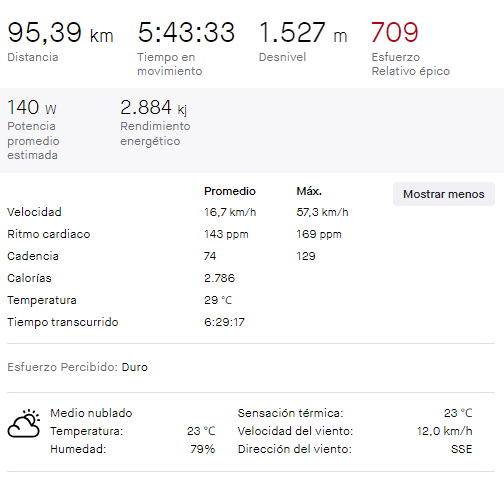

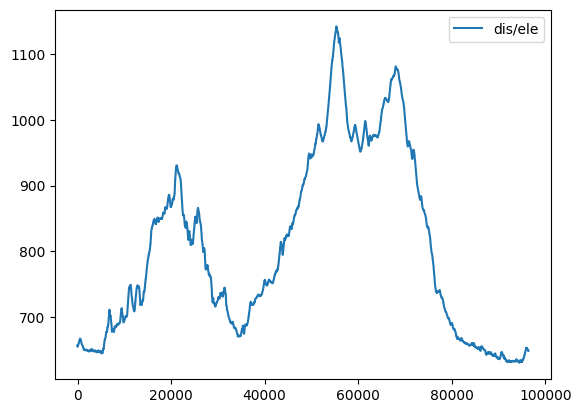

In [ ]:
# Dibujamos distancia vs elevación
plt.plot(distancia, elevacion, label='dis/ele')
plt.legend()
plt.show()


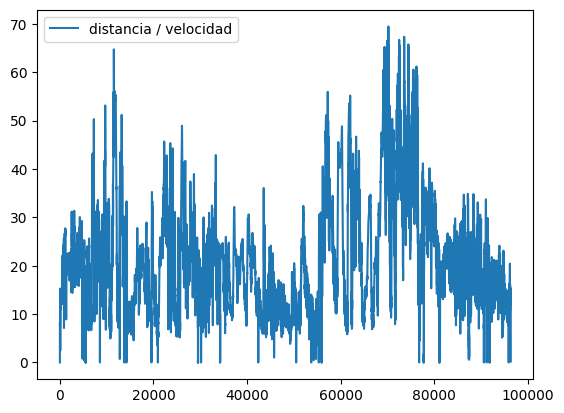

In [ ]:
plt.plot(distancia, velocidad, label='distancia / velocidad')
plt.legend()
plt.show()

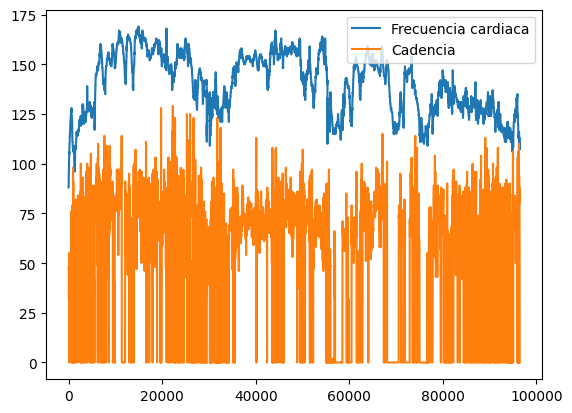

In [ ]:
plt.plot(distancia, heart_rate, label='Frecuencia cardiaca')
plt.plot(distancia, cadence, label='Cadencia')
plt.legend()
plt.show()

Un dato importante en un entrenamiento ciclístico son las zonas de ritmo cardiaco utilizadas durante el mismo. Las *zonas de ritmo cardiaco* dependen de cada persona y tienen como base las pulsaciones máximas que la persona puede tener.Este parámetro se llama *FCM (frecuencia cardiaca maxima)*. La FCM se calcula haciendo un esfuerzo máximo y viendo las pulsaciones en ese momento  o, si no se quiere arriesgar, a 220 le restamos la edad. Las zonas de ritmo cardiaco se determinan  de la siguiente manera:

- Zona 1: Muy ligera, del 50 al 60 por ciento de la FCM.
- Zona 2: Ligero, del 60 al 70 por ciento de la FCM.
- Zona 3: Moderada, del 70 al 80 por ciento de la FCM.
- Zona 4: Difícil, del 80 al 90 por ciento de la FCM.
- Zona 5: Muy duro, del 90 al 100 por ciento de la FCM.

En el caso de  el recorrido anterior la persona tiene una FCM de 170, por lo tanto

- Zona 1: Muy ligera, menor al 60 por ciento de la FCM.
- Zona 2: Ligero, del 60 al 70 por ciento de la FCM.
- Zona 3: Moderada, del 70 al 80 por ciento de la FCM.
- Zona 4: Difícil, del 80 al 90 por ciento de la FCM.
- Zona 5: Muy duro, del 90 al 100 por ciento de la FCM.

In [ ]:
FCM = 170
zona_1 = FCM * 0.58
zona_2 = FCM * 0.77
zona_3 = FCM * 0.87
zona_4 = FCM * 0.96

print('Zona 1: hasta',round(zona_1),'ppm.')
print('Zona 2: de',round(zona_1) + 1,'a',round(zona_2),'ppm.')
print('Zona 3: de',round(zona_2) + 1,'a',round(zona_3),'ppm.')
print('Zona 4: de',round(zona_3) + 1,'a',round(zona_4),'ppm.')
print('Zona 5: desde',round(zona_4) + 1,'ppm.')

Zona 1: hasta 99 ppm.
Zona 2: de 100 a 131 ppm.
Zona 3: de 132 a 148 ppm.
Zona 4: de 149 a 163 ppm.
Zona 5: desde 164 ppm.


Hagamos un gráfico de barras que nos indique cuanto tiempo ha estado el ciclista en cada zona.

Como primer paso,  hagamos las máscaras por zona:

In [ ]:
mask_1 = (heart_rate <= round(zona_1))
mask_2 = (round(zona_1) < heart_rate) & (heart_rate <= round(zona_2))
mask_3 = (round(zona_2) < heart_rate) & (heart_rate <= round(zona_3))
mask_4 = (round(zona_3) < heart_rate) & (heart_rate <= round(zona_4))
mask_5 = (round(zona_4) < heart_rate )

z1, z2, z3, z4, z5 = len(heart_rate[mask_1]), len(heart_rate[mask_2]), len(heart_rate[mask_3]), len(heart_rate[mask_4]), len(heart_rate[mask_5])
zonas = np.array([z1, z2, z3, z4, z5])
total = np.sum(zonas)
print(total, zonas)

15740 [  27 3924 3931 7101  757]


Si suponemos que  las muestras se distribuyen uniformemente en el tiempo, lo cual no es necesariamente cierto, el porcentaje de permanencia en cada zona está en relación directa con la cantidad de muestras.

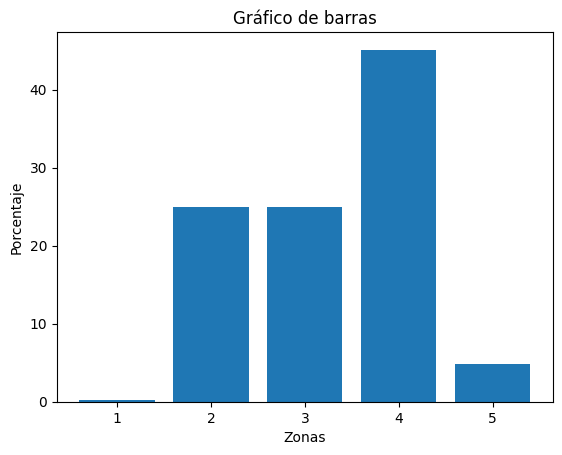

In [ ]:
x = np.arange(1, 6)
y = zonas / total * 100
plt.bar(x, y, align = 'center')
plt.title('Gráfico de barras')
plt.ylabel('Porcentaje')
plt.xlabel('Zonas')
plt.show()